# Proyecto 11 - Luis G

In [2]:
# Importar librerias

import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats as st
import numpy as np
import seaborn as sns
from statsmodels.stats.proportion import proportions_ztest

In [3]:
# Importar dataset

df = pd.read_csv("logs_exp_us.csv", sep = "\t")

## Procesamiento de datos

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


In [5]:
df.head()

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


In [6]:
# Nombres de columna:

df.columns = ['event_name','device_id','event_ts','group']

# Cambiar timestamp a formato date a partir de Unix epoch

df['event_ts'] = pd.to_datetime(df['event_ts'], unit='s')

# Cambiar grupo para mejorar lectura

def nameGroup(data):
    if data == 246:
        return 'A1'
    elif data == 247:
        return 'A2'
    else:
        return 'B'

df['group'] = df['group'].apply(nameGroup)

df.head()

,event_name,device_id,event_ts,group
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,A1
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,A1
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,B
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,B
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,B


In [7]:
# Verificar longitud de la recopilacion de datos

df['event_ts'].describe()

count                           244126
mean     2019-08-04 10:18:35.842716160
min                2019-07-25 04:43:36
25%      2019-08-02 14:36:20.249999872
50%                2019-08-04 11:49:55
75%                2019-08-06 06:55:11
max                2019-08-07 21:15:17
Name: event_ts, dtype: object

- Vemos que apenas y son dos semanas de recopilación de datos, podríamos ser más específicos en los eventos y extraer hasta las horas.

In [8]:
# Extracción de columnas con valores del date

df['month'] = df['event_ts'].dt.month
df['day'] = df['event_ts'].dt.day
df['hour'] = df['event_ts'].dt.hour

df.head()

,event_name,device_id,event_ts,group,month,day,hour
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,A1,7,25,4
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,A1,7,25,11
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,B,7,25,11
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,B,7,25,11
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,B,7,25,11


## Análisis inicial

In [9]:
# Balance de los grupos

df['group'].value_counts().reset_index()

,group,count
0,B,85747
1,A1,80304
2,A2,78075


- Podemos ver que los grupos están bastante balanceados, con eso no afecta a nuestro análisis.

In [10]:
# Usuarios únicos por grupo

df.groupby('group')['device_id'].nunique().reset_index()

,group,device_id
0,A1,2489
1,A2,2520
2,B,2542


- De igual forma, los usuarios únicos por grupo no fluctúan

In [11]:
# Promedio de eventos por usuario

events_per_user = df.groupby('device_id')['event_name'].count().reset_index()

events_per_user['event_name'].mean()

np.float64(32.33028737915508)

- Contamos con un promedio de 32 eventos por usuario.
- Me parece un número elevado pero es posible que haya mucha indecisión al momento de realizar una compra, a la par que se registra el evento de hacer varias compras.

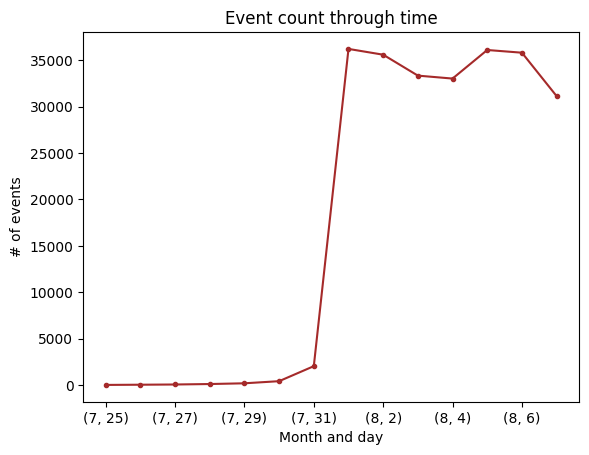

In [12]:
# Cantidad de eventos a lo largo del tiempo

events_in_time = df.groupby(['month','day']).agg(event_count = ('event_name','count'))

events_in_time.plot(kind='line',
                    title= 'Event count through time',
                    ylabel= '# of events',
                    xlabel= 'Month and day',
                    marker='.',
                    color='brown',
                    legend=False
                    
                    )

plt.show()



- Con este gráfico podemos ver que realmente los eventos sucedidos durante el mes de julio no parecen haber sido registrados intencionalmente, pues hay muy pocos eventos para esos días.
- Eliminaremos esos registros y quitaremos la columna month para tener un dataframe más conciso.

In [13]:
# Limpieza del dataframe

df2 = df[df['month'] == 8].reset_index(drop=True)
df2 = df2.drop('month',axis=1)


df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 241298 entries, 0 to 241297
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   event_name  241298 non-null  object        
 1   device_id   241298 non-null  int64         
 2   event_ts    241298 non-null  datetime64[ns]
 3   group       241298 non-null  object        
 4   day         241298 non-null  int32         
 5   hour        241298 non-null  int32         
dtypes: datetime64[ns](1), int32(2), int64(1), object(2)
memory usage: 9.2+ MB


In [14]:
# Conteo de eventos por grupo y usuarios nuevamente, después de limpiar los datos

df2.groupby('group')['event_name'].count()

group
A1    79425
A2    77147
B     84726
Name: event_name, dtype: int64

In [15]:
df2.groupby('group')['device_id'].count()

group
A1    79425
A2    77147
B     84726
Name: device_id, dtype: int64

In [16]:
np.percentile(df['event_ts'],[1,1.15,1.16])

array(['2019-07-31T22:02:36.000000000', '2019-07-31T23:39:59.312500000',
       '2019-08-01T00:08:58.850000000'], dtype='datetime64[ns]')

- Comprobamos que estamos perdiendo muy pocos datos al momento de retirar los registros antiguos, del mes de julio, para el análisis.
- Estos datos retirados representan aproximadamente el 1.15% de los datos.

In [17]:
# Crear embudo de eventos

events_funnel = df2['event_name'].value_counts().reset_index() # Datos

events_funnel

,event_name,count
0,MainScreenAppear,117431
1,OffersScreenAppear,46350
2,CartScreenAppear,42365
3,PaymentScreenSuccessful,34113
4,Tutorial,1039


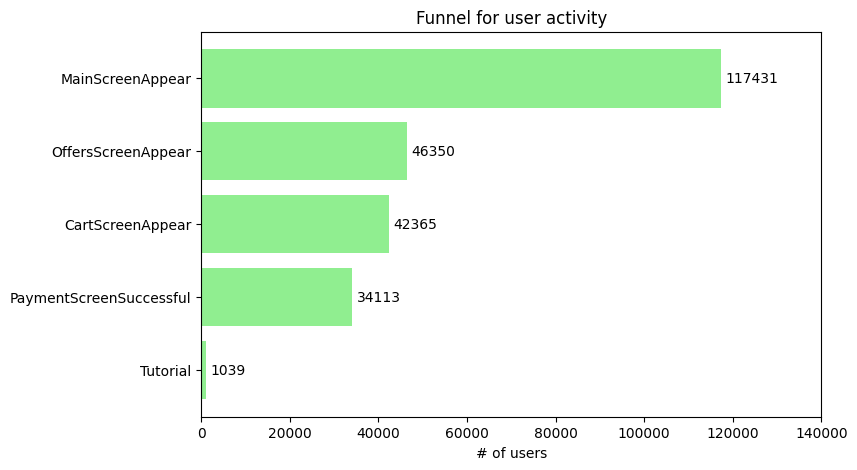

In [18]:
# Gráfico del embudo de eventos

plt.figure(figsize=(8,5))
funnel_bars = plt.barh(events_funnel['event_name'], events_funnel['count'], color='lightgreen')

plt.title('Funnel for user activity')
plt.xlabel('# of users')
plt.gca().invert_yaxis()

for bar in funnel_bars:
    width = bar.get_width()  
    plt.text(width + 1000,             
             bar.get_y() + bar.get_height()/2, 
             f'{int(width)}',         
             va='center')              

plt.xlim(0,140000)
plt.show()

- Observamos que en general se sigue una línea de eventos normales al hacer compras en un sitio web, excepto cuando llegamos a la parte del tutorial.
- Necesitaríamos más detalles de qué se trata ese tutorial; pero parece ser que es un paso no consecutivo al momento de hacer una compra. Se entiende más como una ayuda para cuando ya se adquirió el producto.

In [19]:
# Cantidad de usuarios por accion

funnel_users_events = df2.groupby('event_name')['device_id'].nunique().reset_index().sort_values('device_id',ascending=False)

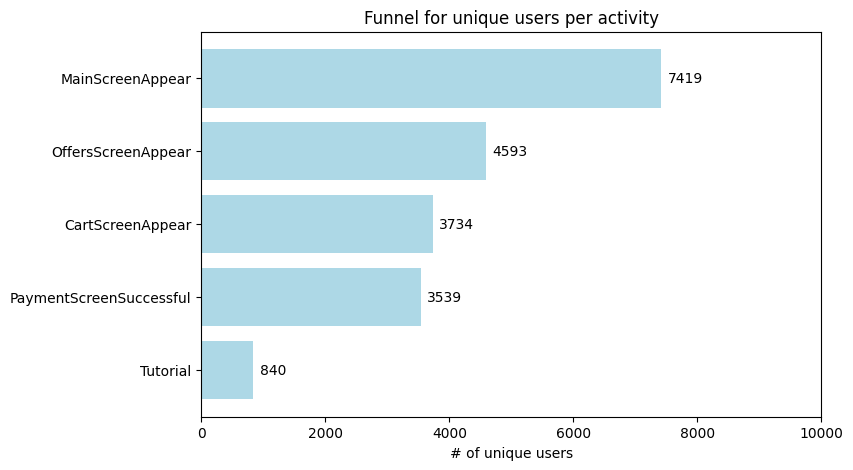

In [20]:
# Gráfico del embudo de usuarios únicos por evento

plt.figure(figsize=(8,5))
funnel_bars = plt.barh(funnel_users_events['event_name'], funnel_users_events['device_id'], color='lightblue')

plt.title('Funnel for unique users per activity')
plt.xlabel('# of unique users')
plt.gca().invert_yaxis()

for bar in funnel_bars:
    width = bar.get_width()  
    plt.text(width + 100,             
             bar.get_y() + bar.get_height()/2, 
             f'{int(width)}',         
             va='center')              

plt.xlim(0,10000)
plt.show()

- Seguimos observando un camino lineal respecto a la compra por el sitio web; las personas llegan a la página principal, buscan ofertas, si les interesa algo lo colocan en su carrito y después realizan el pago.
- Continuamos con la duda respecto a la pestaña de tutorial, pero con esta gráfica vs la anterior, podemos ver que el tutorial es utilizado por varios usuarios que llegan a este punto.

In [21]:
# Renombrar columnas para mejor lectura

events_funnel.columns = ['event_name','event_count']
funnel_users_events.columns = ['event_name','nunique_users']

# Merge de dataframes

general_funnel = events_funnel.merge(funnel_users_events, on = 'event_name')
general_funnel['prop_event_user'] = (general_funnel['nunique_users'] / general_funnel['event_count']).round(3)

general_funnel

,event_name,event_count,nunique_users,prop_event_user
0,MainScreenAppear,117431,7419,0.063
1,OffersScreenAppear,46350,4593,0.099
2,CartScreenAppear,42365,3734,0.088
3,PaymentScreenSuccessful,34113,3539,0.104
4,Tutorial,1039,840,0.808


- De entrada confirmamos lo visto en el tutorial, ya que un 80% de usuarios únicos llegan ahí, dando a entender aún más que es gente que busca directamente ayuda por algo del producto que adquirieron.

- Para los demás eventos, observamos que las personas suelen estar oscilando mucho entre las diferentes páginas antes de llegar a un pago mediante el portal web.

- ¿Será posible que realicen varias veces el proceso de meter al carrito algún producto? o bien, ¿quizá muestran indecisión al momento de realizar una compra?

In [22]:
general_funnel['retention'] = 100.0

general_funnel.loc[1:,'retention'] = (general_funnel['nunique_users'][1:].values / general_funnel['nunique_users'][:-1].values) * 100

general_funnel['retention'] = general_funnel['retention'].round(2)

general_funnel

,event_name,event_count,nunique_users,prop_event_user,retention
0,MainScreenAppear,117431,7419,0.063,100.00
1,OffersScreenAppear,46350,4593,0.099,61.91
2,CartScreenAppear,42365,3734,0.088,81.30
3,PaymentScreenSuccessful,34113,3539,0.104,94.78
4,Tutorial,1039,840,0.808,23.74


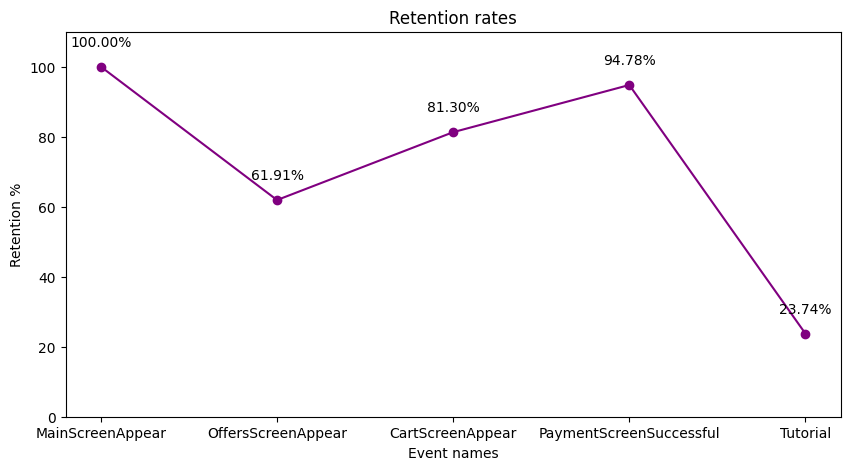

In [ ]:
# Graficar la retención

plt.figure(figsize=(10, 5))
plt.plot(general_funnel['event_name'], general_funnel['retention'], marker='o', color='purple')
plt.title("Retention rates")
plt.xlabel('Event names')
plt.ylabel("Retention %")
plt.ylim(0,110)

for i, txt in enumerate(general_funnel['retention']):
    plt.text(general_funnel['event_name'][i], txt + 5 , f'{txt:.2f}%', ha='center', va='bottom', fontsize=10)

plt.show()

- Observamos que la etapa en la que más perdemos usuarios es en la de ofertas. 
- Se entiende que es o porque los usuarios no buscan comprar, o bien, cuando compran, van directo por lo que buscan y no están buscando ofertas en sus productos.
- Ignoramos el tutorial porque seguimos la línea de que no es parte del proceso de compra llegar al tutorial, sino que es por consultas aparte.

In [24]:
general_funnel

,event_name,event_count,nunique_users,prop_event_user,retention
0,MainScreenAppear,117431,7419,0.063,100.00
1,OffersScreenAppear,46350,4593,0.099,61.91
2,CartScreenAppear,42365,3734,0.088,81.30
3,PaymentScreenSuccessful,34113,3539,0.104,94.78
4,Tutorial,1039,840,0.808,23.74


In [25]:
# Porcentaje de usuarios que realizan todo el viaje para la compra de un producto

general_funnel.loc[3,'nunique_users'] / general_funnel.loc[0,'nunique_users']

np.float64(0.47701846610055265)

- De un 100% de usuarios únicos que ingresan al portal, contamos con un 47% de usuarios que realizan todo el proceso de una compra en el portal web.

## Cálculos estadísticos

In [26]:
# Revisaremos si hay diferencia estadísticamente significativa entre los grupos de control
# Para ello, revisaremos el promedio de eventos por usuario

# Retiraremos el evento de tutorial, pues no es relevante en cuanto a las compras de los clientes

df_clean = df2[df2['event_name'] != 'Tutorial'].reset_index(drop=True)

# Revisaremos el conteo de evento por grupos

df_clean.groupby('group')['event_name'].count().reset_index()

,group,event_name
0,A1,79102
1,A2,76804
2,B,84353


- El conteo por grupos sigue siendo bastante similar, procederemos a revisar las diferencias estadísicamente significativas de los grupos de control.
- Nos mantenemos en el plan de hacerlo mediante el promedio de eventos por usuario.

In [27]:
df_grouped = df_clean.groupby(['group','device_id'])['event_name'].count().reset_index()

df_grouped.groupby('group')['event_name'].mean() # Calculo del promedio de eventos por usuario por grupo

group
A1    31.857431
A2    30.574841
B     33.275345
Name: event_name, dtype: float64

In [28]:
# Revisar normalidad de las distribuciones | Shapiro Wilk

# Ho = Las distribuciones siguen una distribución normal
# Ha = Las distribuciones no siguen una distribución normal

alpha = 0.05

A1_group = df_grouped[df_grouped['group'] == 'A1']['event_name']
A2_group = df_grouped[df_grouped['group'] == 'A2']['event_name']

shapiro_A1 = st.shapiro(A1_group)
shapiro_A2 = st.shapiro(A2_group)

print(f"Shapiro A1: {shapiro_A1.statistic}, pvalue A1: {shapiro_A1.pvalue}")
print(f"Shapiro A2: {shapiro_A2.statistic}, pvalue A2: {shapiro_A2.pvalue}")

Shapiro A1: 0.29869930301127934, pvalue A1: 1.024318497560941e-70
Shapiro A2: 0.3322829160143268, pvalue A2: 5.205634148518215e-70


- Concluimos que las distribuciones no siguen una distribución normal ya que el pvalue de ambas es menor a 0.05. Por ello, ocuparemos la prueba de Mann Whitney U

In [29]:
# Revisar si hay diferencia estadísticamente significativa entre los grupos de control mediante el promedio de eventos por usuario.

# Ho = El promedio de eventos por usuario es estadisticamente igual en ambas distribuciones
# Ha = El promedio de eventos por usuario es estadisticamente diferente en ambas distribuciones

results1 = st.mannwhitneyu(A1_group, A2_group)

print(f"pvalue: {results1.pvalue}")

if results1.pvalue < alpha:
    print("Rechazamos hipótesis nula, hay diferencia en los promedios de ambas distribuciones")
else:
    print("No podemos rechazar la hipótesis nula, las distribuciones se comportan estadisticamente similares.")

pvalue: 0.8432445759738187
No podemos rechazar la hipótesis nula, las distribuciones se comportan estadisticamente similares.


- Con esto concluimos que los grupos de control son lo suficientemente buenos para poder proceder con la comparación con el grupo de tratamiento (B)

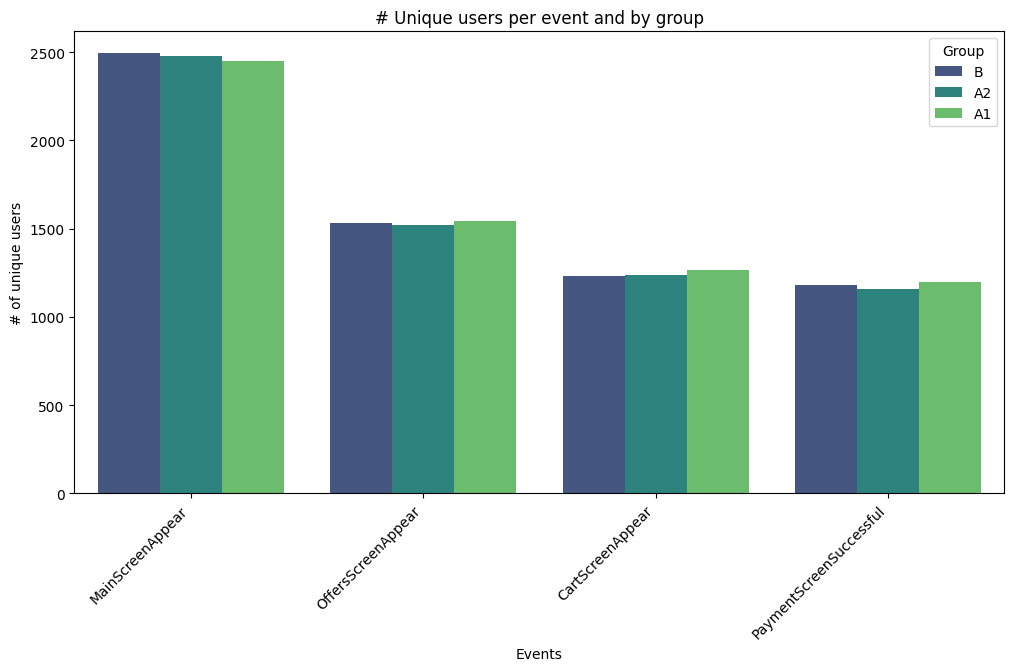

In [30]:
# Cantidad de usuarios únicos en cada evento, dividido por grupo

events_nuser = df_clean.groupby(['group','event_name'])['device_id'].nunique().reset_index().sort_values(by=['device_id','group'], ascending=False)

plt.figure(figsize=(12, 6))

# Usar seaborn para un gráfico de barras agrupadas
sns.barplot(data=events_nuser, x='event_name', y='device_id', hue='group', palette='viridis')

plt.xlabel('Events')
plt.ylabel('# of unique users')
plt.title('# Unique users per event and by group')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Group')

plt.show()

- Observamos que está bastante balanceado el número de usuarios únicos que realizaron cada acción aún dividiéndolos por su grupo correspondiente.
- Procedemos con los análisis siguientes, referente a la proporción de usuarios por evento y por grupo.

In [38]:
df_clean

,event_name,device_id,event_ts,group,day,hour
0,MainScreenAppear,3737462046622621720,2019-08-01 00:08:00,A1,1,0
1,MainScreenAppear,3737462046622621720,2019-08-01 00:08:55,A1,1,0
2,OffersScreenAppear,3737462046622621720,2019-08-01 00:08:58,A1,1,0
3,MainScreenAppear,1433840883824088890,2019-08-01 00:08:59,A2,1,0
4,MainScreenAppear,4899590676214355127,2019-08-01 00:10:15,A2,1,0
...,...,...,...,...,...,...
240254,MainScreenAppear,4599628364049201812,2019-08-07 21:12:25,A2,7,21
240255,MainScreenAppear,5849806612437486590,2019-08-07 21:13:59,A1,7,21
240256,MainScreenAppear,5746969938801999050,2019-08-07 21:14:43,A1,7,21
240257,MainScreenAppear,5746969938801999050,2019-08-07 21:14:58,A1,7,21


In [ ]:
# Tasas de conversión A1

funnel_A1 = df_clean.query("group =='A1'").pivot_table(index = 'event_name', values = 'device_id', aggfunc='nunique').sort_values('device_id',ascending=False)

n_A1 = funnel_A1['device_id'].max()
funnel_A1['convA1'] = 100 * funnel_A1['device_id'] / n_A1
funnel_A1.drop(columns='device_id',inplace=True)

funnel_A1

,convA1
event_name,
MainScreenAppear,100.000000
OffersScreenAppear,62.938776
CartScreenAppear,51.673469
PaymentScreenSuccessful,48.979592


In [ ]:
# Tasas de conversión A2

funnel_A2 = df_clean.query("group =='A2'").pivot_table(index = 'event_name', values = 'device_id', aggfunc='nunique').sort_values('device_id',ascending=False)

n_A2 = funnel_A2['device_id'].max()
funnel_A2['convA2'] = 100 * funnel_A2['device_id'] / n_A2
funnel_A2.drop(columns='device_id',inplace=True)

funnel_A2

,convA1
event_name,
MainScreenAppear,100.000000
OffersScreenAppear,61.389338
CartScreenAppear,50.000000
PaymentScreenSuccessful,46.768982


In [44]:
# Tasas de conversión B

funnel_B = df_clean.query("group =='B'").pivot_table(index = 'event_name', values = 'device_id', aggfunc='nunique').sort_values('device_id',ascending=False)

n_B = funnel_B['device_id'].max()
funnel_B['convB'] = 100 * funnel_B['device_id'] / n_B
funnel_B.drop(columns='device_id',inplace=True)

funnel_B

,convB
event_name,
MainScreenAppear,100.000000
OffersScreenAppear,61.411953
CartScreenAppear,49.338147
PaymentScreenSuccessful,47.372643


In [48]:
# Funnel general

funnel = funnel_A1.merge(funnel_A2, on='event_name')
funnel = funnel.merge(funnel_B, on = 'event_name')

funnel.columns = ['A1','A2','B']

funnel

,A1,A2,B
event_name,,,
MainScreenAppear,100.000000,100.000000,100.000000
OffersScreenAppear,62.938776,61.389338,61.411953
CartScreenAppear,51.673469,50.000000,49.338147
PaymentScreenSuccessful,48.979592,46.768982,47.372643


### Pruebas de hipótesis

In [46]:
# Observaciones de cada grupo

general_n = pd.Series([n_A1,n_A2,n_B], index= ['A1','A2','B'])

general_n

A1    2450
A2    2476
B     2493
dtype: int64

In [49]:
funnel

,A1,A2,B
event_name,,,
MainScreenAppear,100.000000,100.000000,100.000000
OffersScreenAppear,62.938776,61.389338,61.411953
CartScreenAppear,51.673469,50.000000,49.338147
PaymentScreenSuccessful,48.979592,46.768982,47.372643


In [59]:
# Funcion para pruebas de hipotesis

def prueba_ab(evento, g1, g2, alpha = 0.05):

    # Exitos muestra 1

    p_1 = funnel.loc[evento,g1] / 100
    suc_1 = int(p_1*general_n[g1])

    # Exitos muestra 2

    p_2 = funnel.loc[evento,g2] / 100
    suc_2 = int(p_2*general_n[g2])

    # Consolidar en una lista los exitos y las observaciones

    suc = [suc_1, suc_2]
    obs = [general_n[g1], general_n[g2]]

    # Ejecutar la prueba de hipotesis con test z de proporciones

    z_stat, pval = proportions_ztest(
        count=suc,
        nobs=obs,
        alternative='two-sided')
    
    print(f"Valor p: {pval:.1%}")

    if pval < alpha:
        print("Rechazamos hipótesis nula: Las tasas de conversión son diferentes", flush=True)
    else:
        print("No podemos rechazar hipótesis nula: Las tasas de conversión son iguales", flush=True)

    return pval


In [52]:
funnel

,A1,A2,B
event_name,,,
MainScreenAppear,100.000000,100.000000,100.000000
OffersScreenAppear,62.938776,61.389338,61.411953
CartScreenAppear,51.673469,50.000000,49.338147
PaymentScreenSuccessful,48.979592,46.768982,47.372643


In [63]:
# Pruebas A1 vs A2

print("COMPARACIÓN A1 vs A2")
print("################")
print("\n")

for event in funnel.index[1:]:
    print(f"Evento: {event}")
    print("==============")
    prueba_ab(event, 'A1', 'A2')
    print("\n")


COMPARACIÓN A1 vs A2
################


Evento: OffersScreenAppear
Valor p: 26.2%
No podemos rechazar hipótesis nula: Las tasas de conversión son iguales


Evento: CartScreenAppear
Valor p: 24.0%
No podemos rechazar hipótesis nula: Las tasas de conversión son iguales


Evento: PaymentScreenSuccessful
Valor p: 12.0%
No podemos rechazar hipótesis nula: Las tasas de conversión son iguales




In [64]:
# Pruebas A1 vs B

print("COMPARACIÓN A1 vs B")
print("################")
print("\n")

for event in funnel.index[1:]:
    print(f"Evento: {event}")
    print("==============")
    prueba_ab(event, 'A1', 'B')
    print("\n")

COMPARACIÓN A1 vs B
################


Evento: OffersScreenAppear
Valor p: 25.6%
No podemos rechazar hipótesis nula: Las tasas de conversión son iguales


Evento: CartScreenAppear
Valor p: 10.1%
No podemos rechazar hipótesis nula: Las tasas de conversión son iguales


Evento: PaymentScreenSuccessful
Valor p: 25.8%
No podemos rechazar hipótesis nula: Las tasas de conversión son iguales




In [65]:
# Pruebas A2 vs B

print("COMPARACIÓN A2 vs B")
print("################")
print("\n")

for event in funnel.index[1:]:
    print(f"Evento: {event}")
    print("==============")
    prueba_ab(event, 'A2', 'B')
    print("\n")

COMPARACIÓN A2 vs B
################


Evento: OffersScreenAppear
Valor p: 99.0%
No podemos rechazar hipótesis nula: Las tasas de conversión son iguales


Evento: CartScreenAppear
Valor p: 64.1%
No podemos rechazar hipótesis nula: Las tasas de conversión son iguales


Evento: PaymentScreenSuccessful
Valor p: 67.0%
No podemos rechazar hipótesis nula: Las tasas de conversión son iguales




# Conclusión

- Con las pruebas realizadas, primero que nada, me da la impresión que los grupos de control están bien realizados, puesto que no presentan mayores diferencias y se comportan similares estadísticamente hablando.
- Con esta base, podemos proceder a realizar la comparación de cualquiera de los grupos de control vs el grupo de tratamiento, en este caso, decidí hacer ambos porque ya tenía todo hecho, nada me costaba y sirve que hacia un poco más de labor curiosa.
- Aplicando todas las pruebas en las tasas de conversión, puedo concluir que el cambio en la tipografía de la aplicación parece ser irrelevante al momento de obtener clientes.
- Lo único que valdría la pena explorar es por qué hay ciertas pruebas que tienen pvalues bajos, las cuales, si hubiéramos establecido un valor de significancia más alto, probablemente no habrían pasado la prueba.
- Esto último claro, dependerá de qué tan minuciosos queramos ser con nuestras pruebas a futuro y según los intereses de la empresa que nos contrató